# **Unsupervised learning and data clustering**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
from scipy.stats import norm, boxcox
from sklearn.impute import SimpleImputer

## 1. Data Preparation

The first step in any machine learning project is to collect and prepare the data for analysis. In unsupervised learning, the data does not have predefined labels, so the focus is on cleaning, transforming, and normalizing the data to remove any noise or outliers that may affect the analysis.

### 1.1 Data Collection

In [2]:
df = pd.read_csv("/kaggle/input/ccdata/CC GENERAL.csv")
print(f"shape of dataset: {df.shape}")
df.columns = df.columns.str.capitalize()
df.head()

shape of dataset: (8950, 18)


,Cust_id,Balance,Balance_frequency,Purchases,Oneoff_purchases,Installments_purchases,Cash_advance,Purchases_frequency,Oneoff_purchases_frequency,Purchases_installments_frequency,Cash_advance_frequency,Cash_advance_trx,Purchases_trx,Credit_limit,Payments,Minimum_payments,Prc_full_payment,Tenure
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Cust_id                           8950 non-null   object 
 1   Balance                           8950 non-null   float64
 2   Balance_frequency                 8950 non-null   float64
 3   Purchases                         8950 non-null   float64
 4   Oneoff_purchases                  8950 non-null   float64
 5   Installments_purchases            8950 non-null   float64
 6   Cash_advance                      8950 non-null   float64
 7   Purchases_frequency               8950 non-null   float64
 8   Oneoff_purchases_frequency        8950 non-null   float64
 9   Purchases_installments_frequency  8950 non-null   float64
 10  Cash_advance_frequency            8950 non-null   float64
 11  Cash_advance_trx                  8950 non-null   int64  
 12  Purcha

#### Columns with missing data

In [4]:
df.isna().sum().sort_values(ascending=False).head(2)

Minimum_payments    313
Credit_limit          1
dtype: int64

### 1.2 Data cleaning

Data cleaning involves removing any missing or irrelevant data, as well as correcting any errors or inconsistencies in the data.

In [5]:
df.drop("Cust_id", axis = 1, inplace = True)
df_nan = ['Minimum_payments', 'Credit_limit']

In [6]:
df[['Payments', 'Minimum_payments']][df['Payments'] == 0].head()

,Payments,Minimum_payments
3,0.0,NaN
45,0.0,NaN
47,0.0,NaN
55,0.0,NaN
56,0.0,NaN


In [7]:
df['Minimum_payments'][(df['Payments'] == 0) & (df['Minimum_payments'].isna())] = 0

In [8]:
df.isna().sum().sort_values(ascending=False).head(2)

Minimum_payments    73
Credit_limit         1
dtype: int64

In [9]:
imputer = SimpleImputer(strategy='mean')
imputed_missing_values = imputer.fit_transform(df[df_nan])
df[df_nan] = imputed_missing_values

In [10]:
df.isna().sum().sort_values(ascending=False).head(2)

Balance                   0
Cash_advance_frequency    0
dtype: int64

In [11]:
round(df.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
Balance,8950.0,1564.47,2081.53,0.0,128.28,873.39,2054.14,19043.14
Balance_frequency,8950.0,0.88,0.24,0.0,0.89,1.00,1.00,1.00
Purchases,8950.0,1003.20,2136.63,0.0,39.64,361.28,1110.13,49039.57
Oneoff_purchases,8950.0,592.44,1659.89,0.0,0.00,38.00,577.40,40761.25
Installments_purchases,8950.0,411.07,904.34,0.0,0.00,89.00,468.64,22500.00
Cash_advance,8950.0,978.87,2097.16,0.0,0.00,0.00,1113.82,47137.21
Purchases_frequency,8950.0,0.49,0.40,0.0,0.08,0.50,0.92,1.00
Oneoff_purchases_frequency,8950.0,0.20,0.30,0.0,0.00,0.08,0.30,1.00
Purchases_installments_frequency,8950.0,0.36,0.40,0.0,0.00,0.17,0.75,1.00
Cash_advance_frequency,8950.0,0.14,0.20,0.0,0.00,0.00,0.22,1.50


### 1.3 Data exploration
Data exploration involves visualizing and analyzing the data to gain insights into its structure and characteristics. This can help to identify any patterns or outliers that may need to be addressed before the analysis begins.

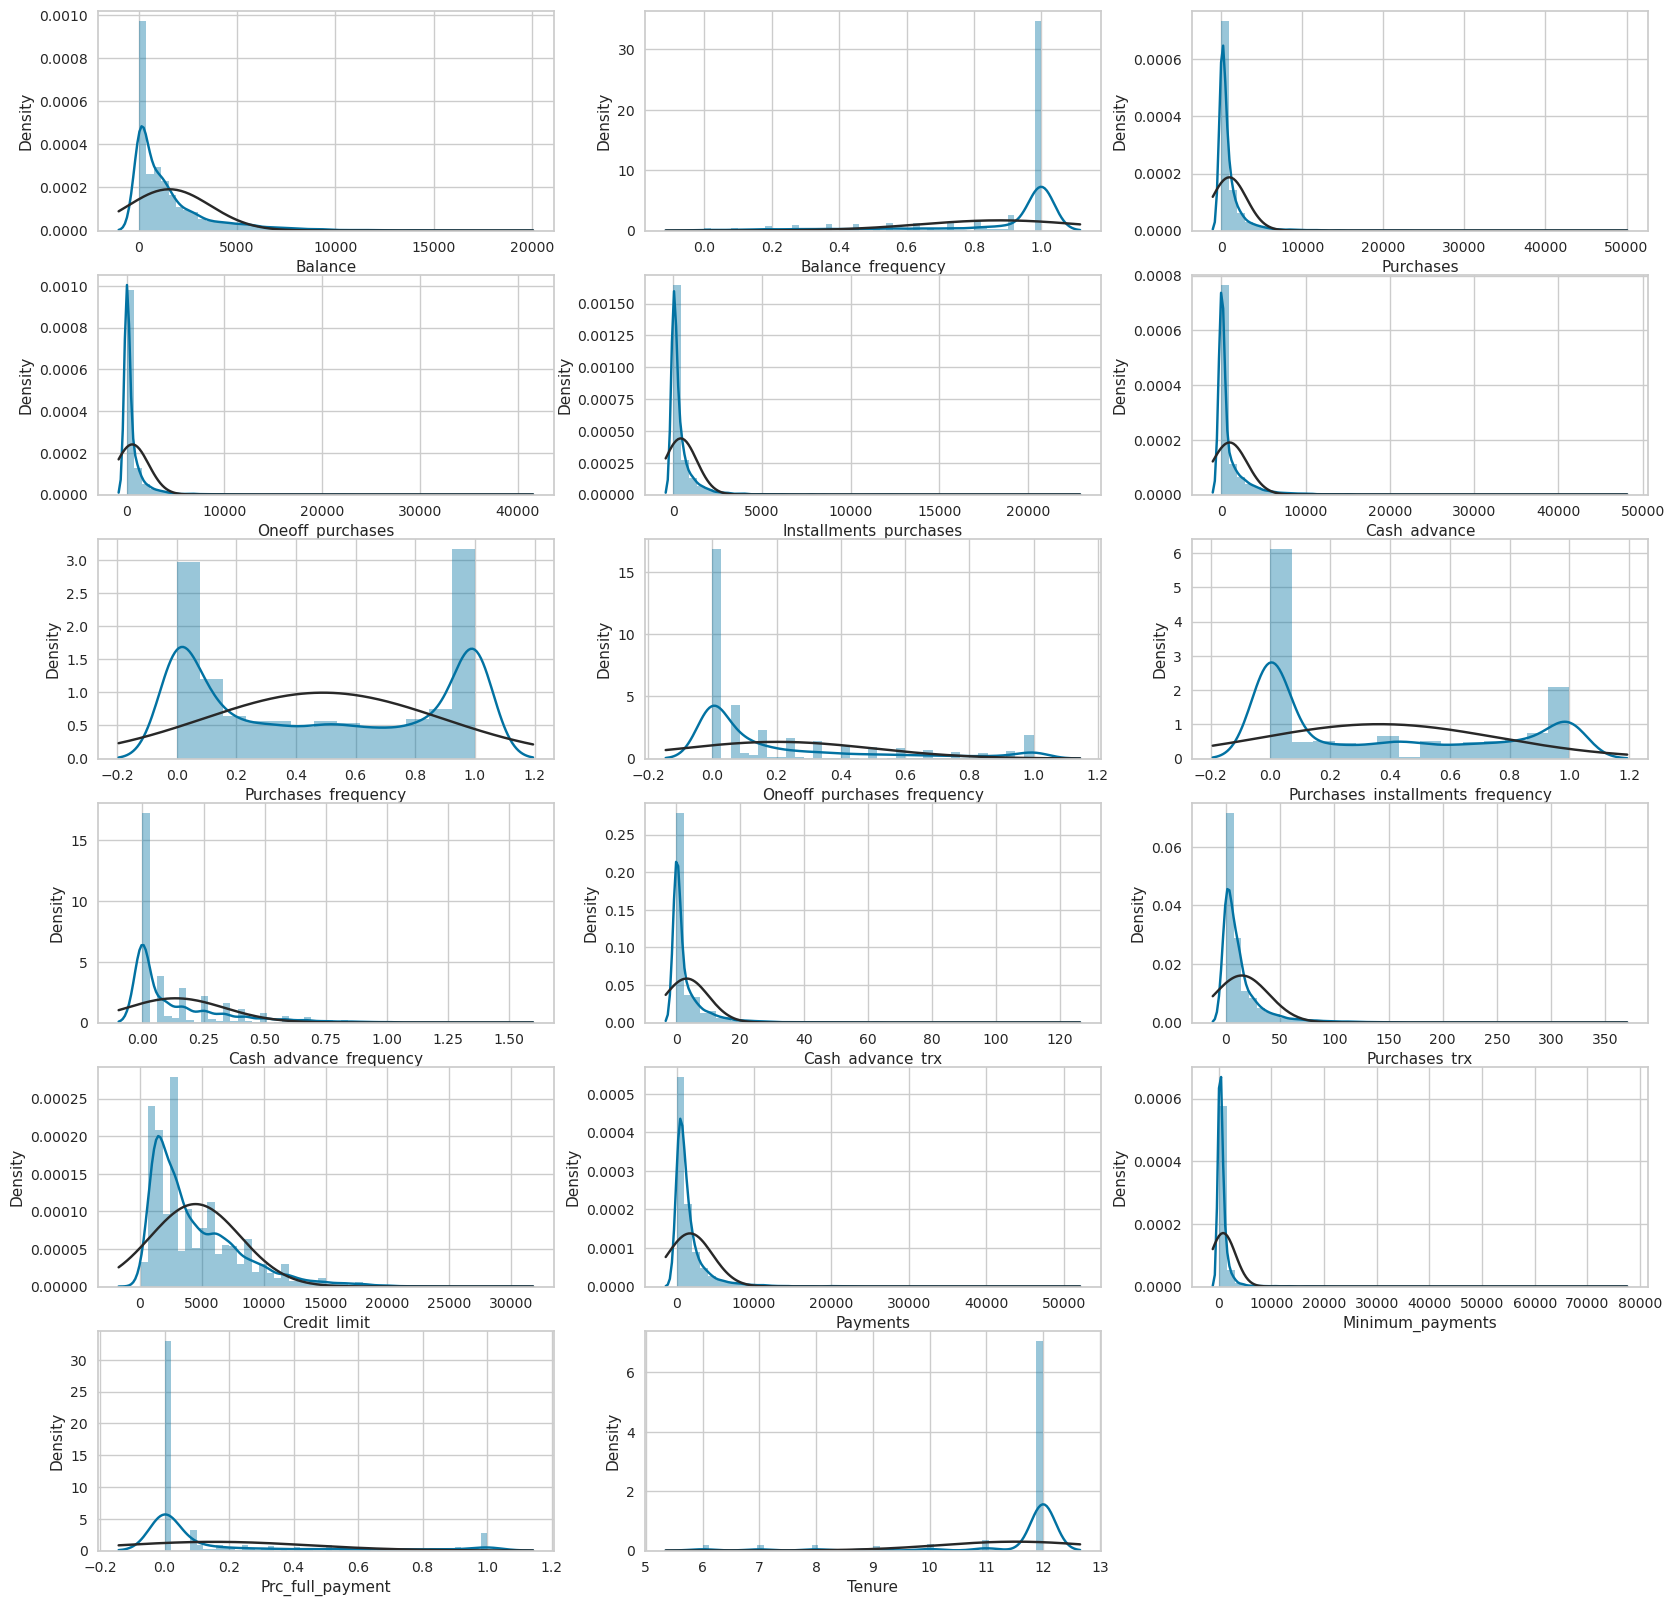

In [12]:
plt.figure(figsize=(20,20))
for i, col in enumerate(df.columns):
    ax = plt.subplot(6, 3, i+1)
    sns.distplot(df[col], ax=ax, fit=norm)
    plt.xlabel(col)
plt.show()

In [13]:
columns = ['Balance', 'Purchases', 'Credit_limit','Payments', 'Minimum_payments']

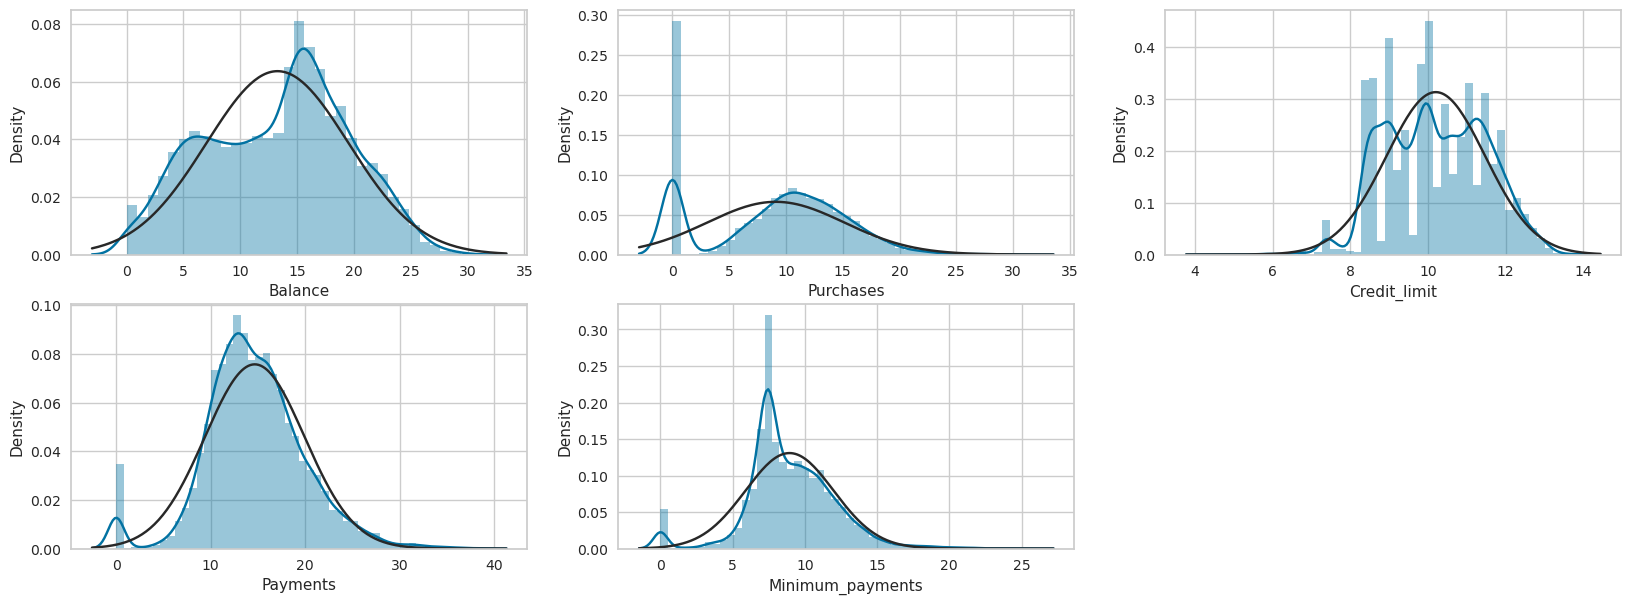

In [14]:
for col in columns:
    df[col] = boxcox(df[col] + 1)[0]
plt.figure(figsize=(20,7))
for i, col in enumerate(columns):
    ax = plt.subplot(2, 3, i+1)
    sns.distplot(df[col], ax=ax, fit=norm)
    plt.xlabel(col)
plt.show()

### 1.4 Data transformation

Data transformation involves converting the data into a format that is suitable for analysis. This may involve scaling or normalizing the data, or transforming it into a different format such as a matrix or graph.

In [15]:
scaler = Normalizer()
df_scaled = scaler.fit_transform(df)
df_scaled.shape

(8950, 17)

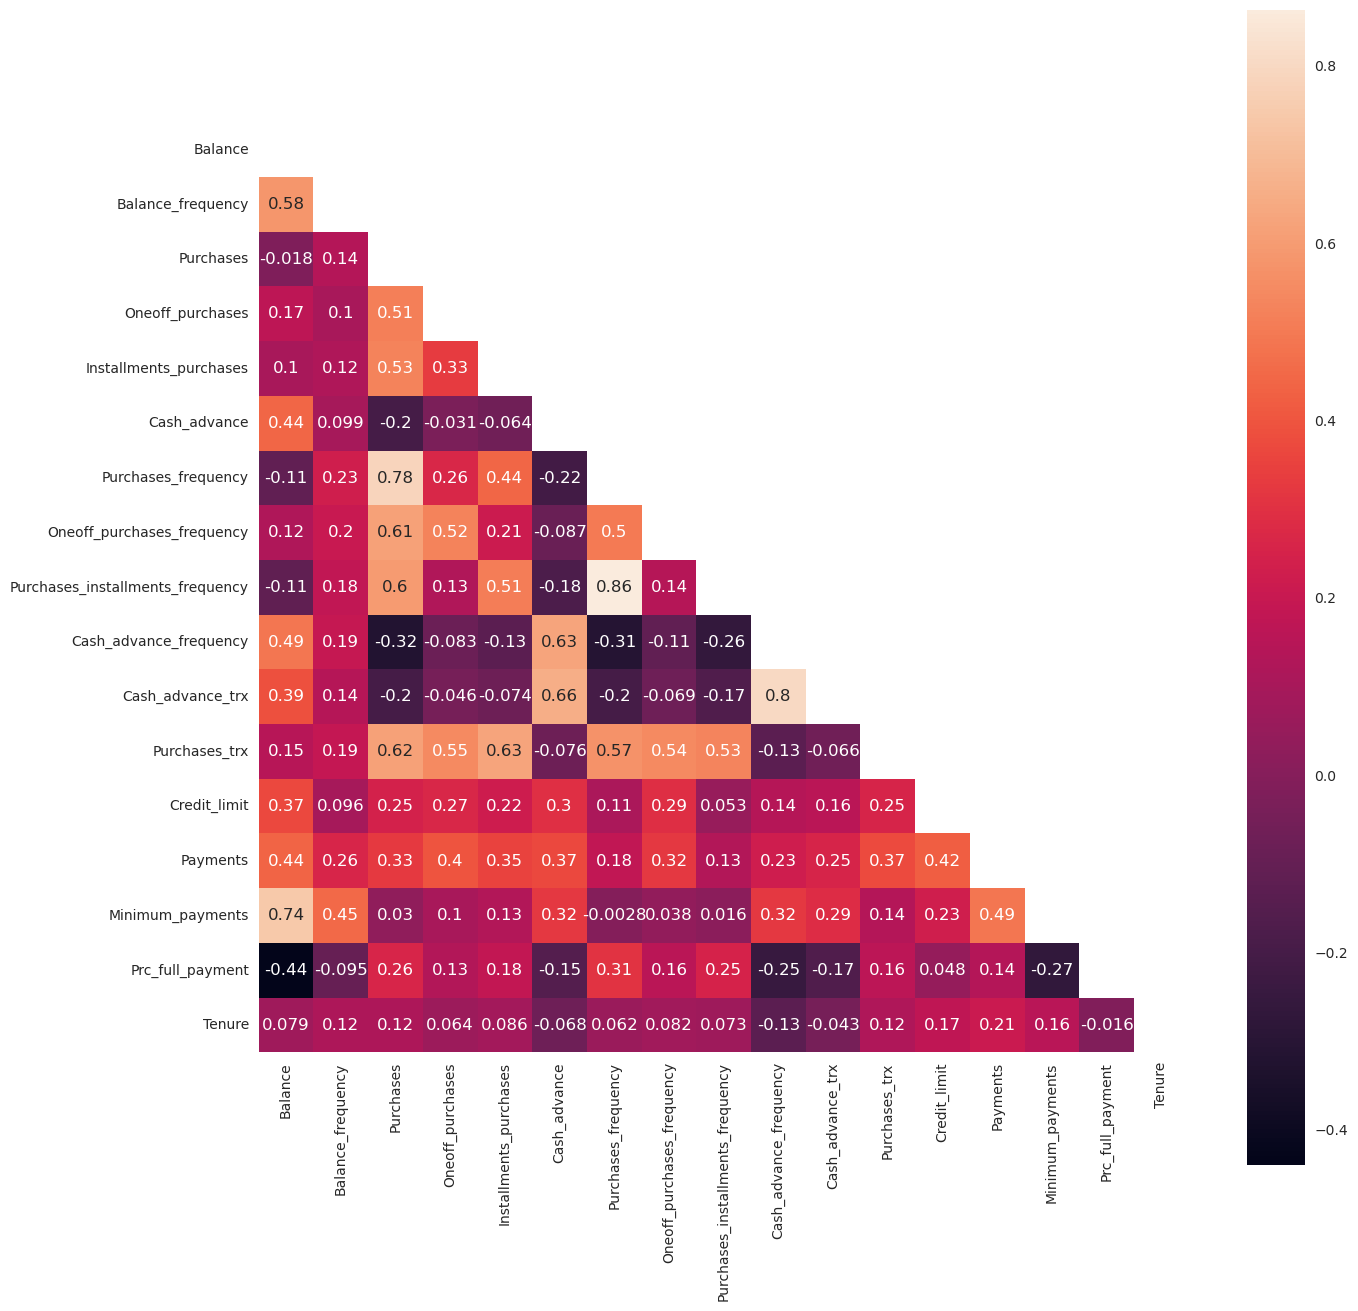

In [16]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True, mask = np.triu(df.corr()), square=True)
plt.show()

## 2. Choosing the algorithm
There are several unsupervised learning algorithms available, each with its own strengths and weaknesses. The choice of algorithm will depend on the type of problem and the nature of the data.

### 2.1 Dimensionality reduction with PCA
Dimensionality reduction algorithms reduce the number of features in the data, while retaining as much information as possible. This can be useful for visualizing high-dimensional data or for reducing the complexity of the data for further analysis.

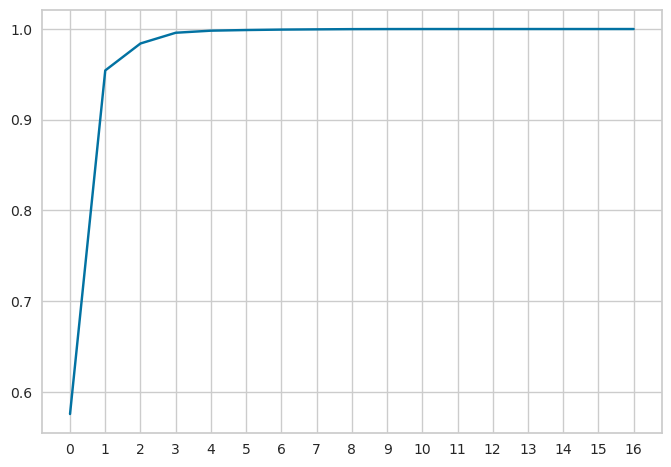

In [17]:
pca = PCA()
pca.fit(df_scaled)
plt.xticks(range(0,17))
sns.lineplot(data=pca.explained_variance_ratio_.cumsum())
plt.show()

In [18]:
pca = PCA(n_components = 2)
train_df = pca.fit_transform(df_scaled)

### 2.2 Clustering with KMeans
Clustering algorithms group similar data points together based on their features. This can be useful for identifying patterns or structure in the data, or for segmenting the data into different groups.

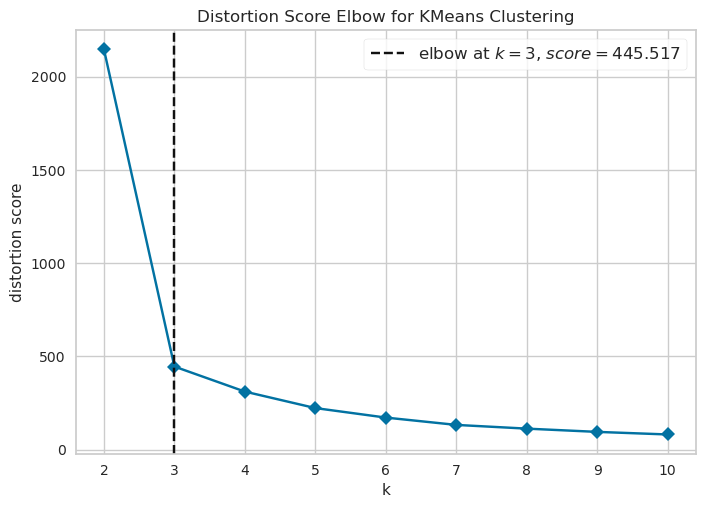

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
kmeans_model = KMeans()
elbow = KElbowVisualizer(kmeans_model, k=10, timings=False)
elbow.fit(train_df)
elbow.show()

In [20]:
kmeans_model = KMeans(n_clusters=3)
kmeans_model.fit(train_df)
labels = kmeans_model.labels_
print(labels)

[2 1 0 ... 2 1 0]


In [21]:
data = pd.DataFrame(columns=['x', 'y'], data=train_df)
data['cluster'] = kmeans_model.predict(data)

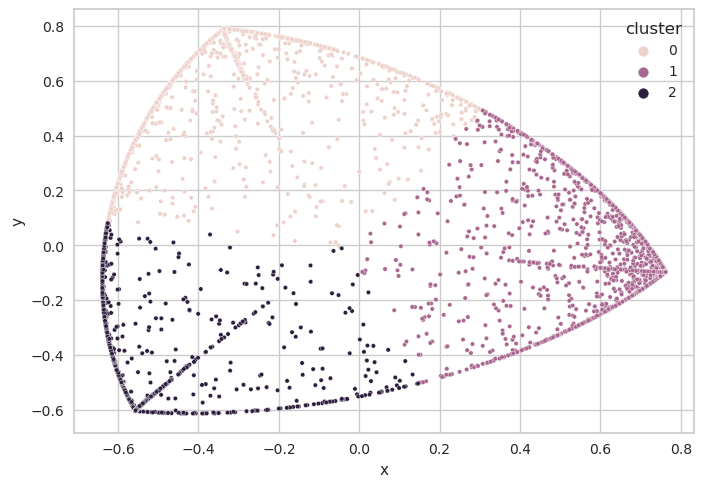

In [22]:
sns.scatterplot(data=data, x='x', y='y', hue='cluster',s=10)
plt.show()

In [23]:
silhouette = metrics.silhouette_score(data[['x', 'y']], data['cluster'])
print('Silhouette score:',silhouette)

Silhouette score: 0.7795402992194506


## 3. Clusters analysis

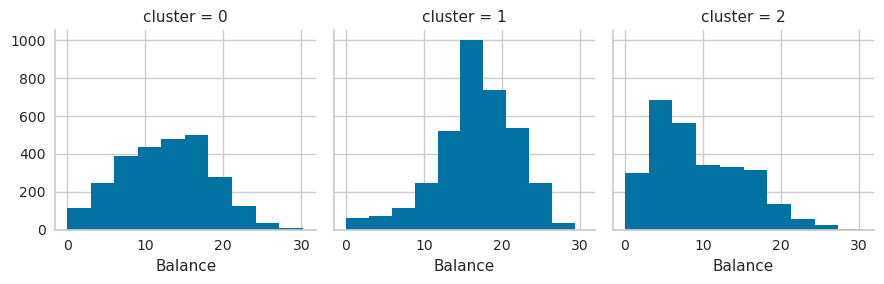

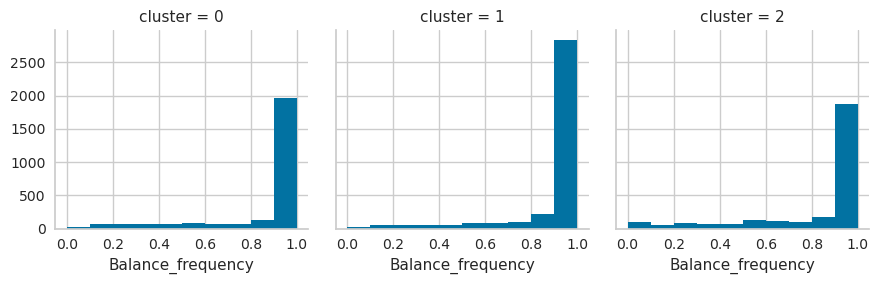

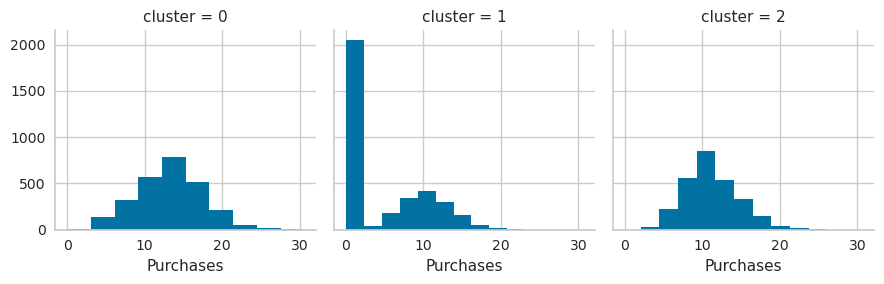

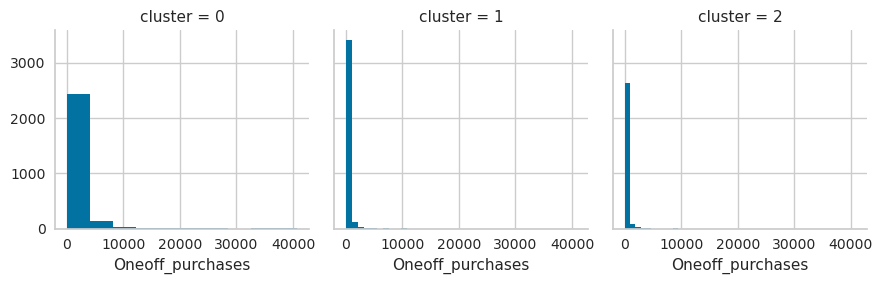

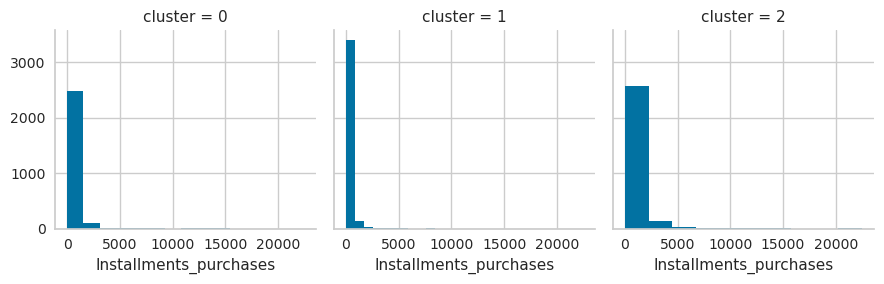

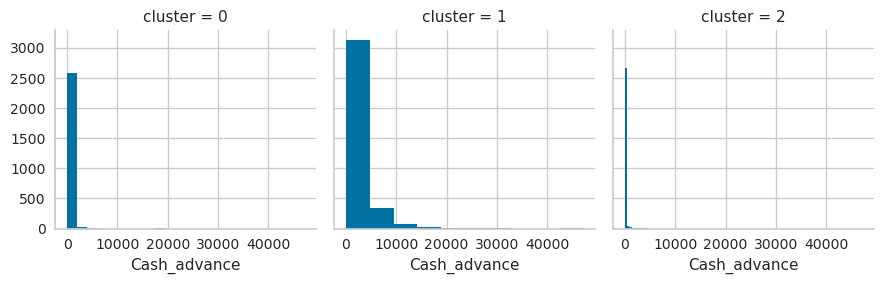

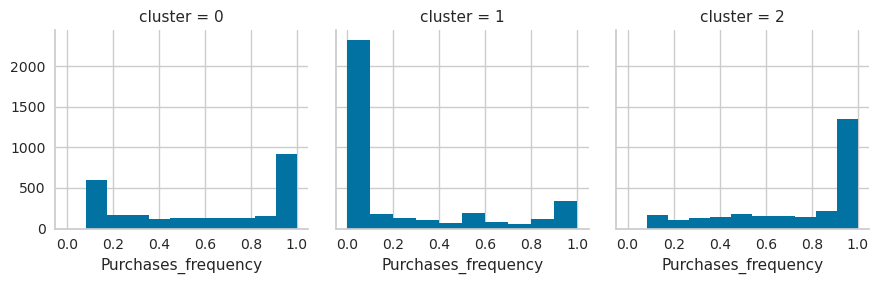

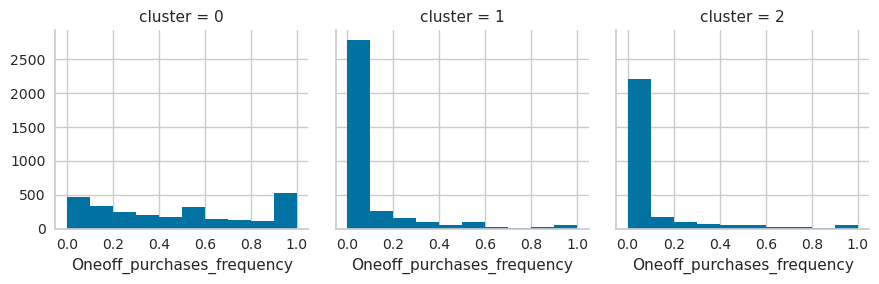

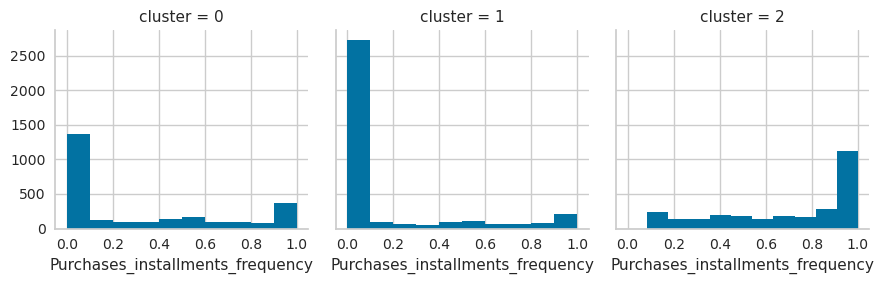

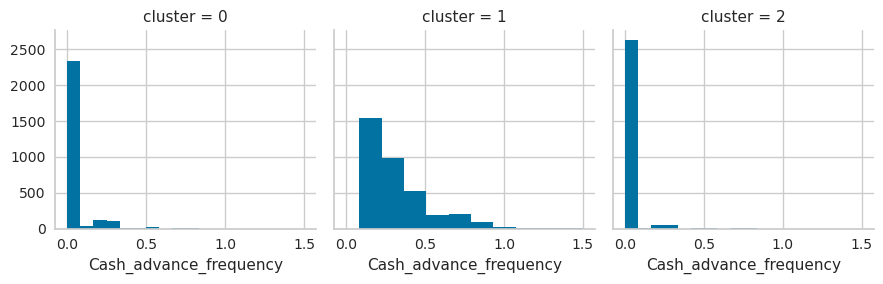

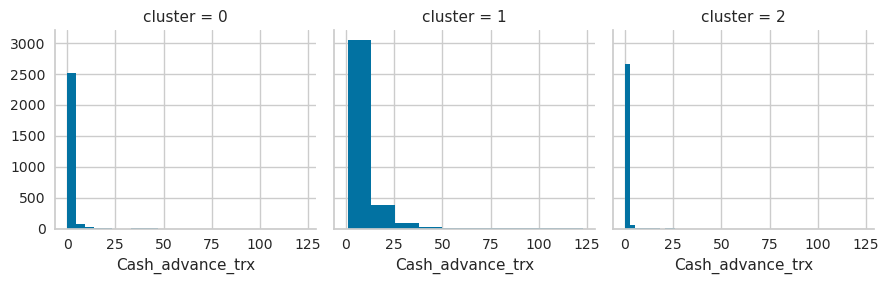

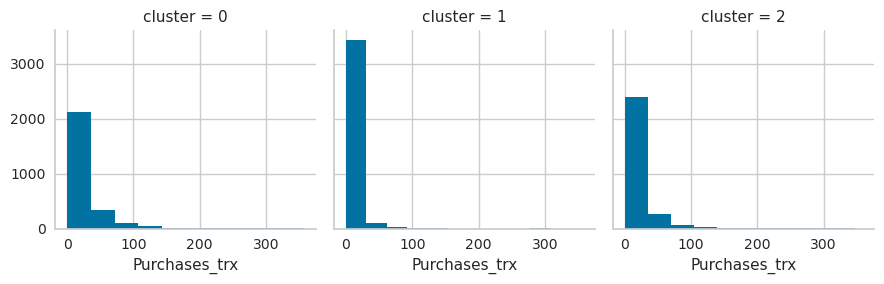

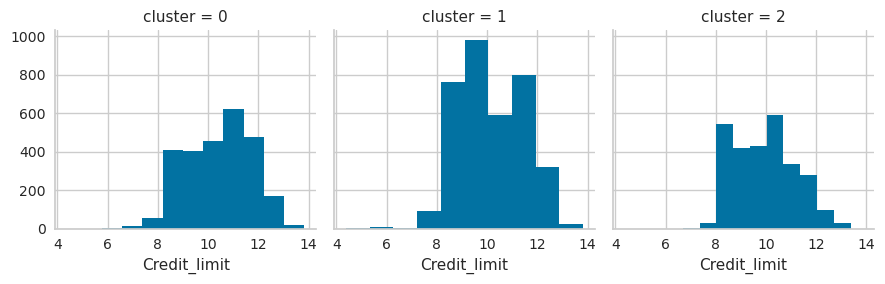

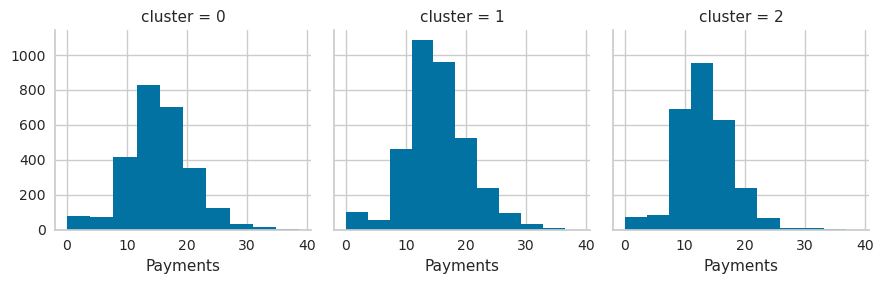

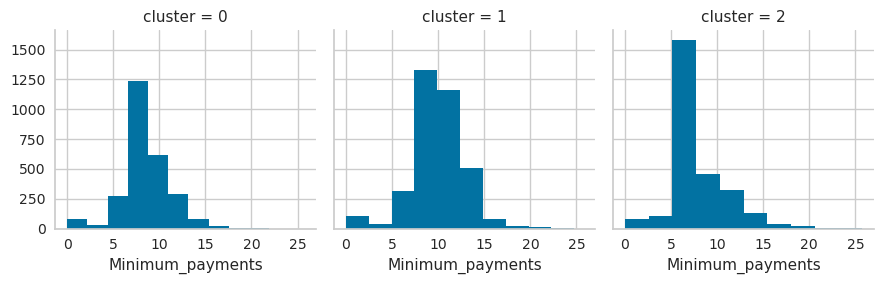

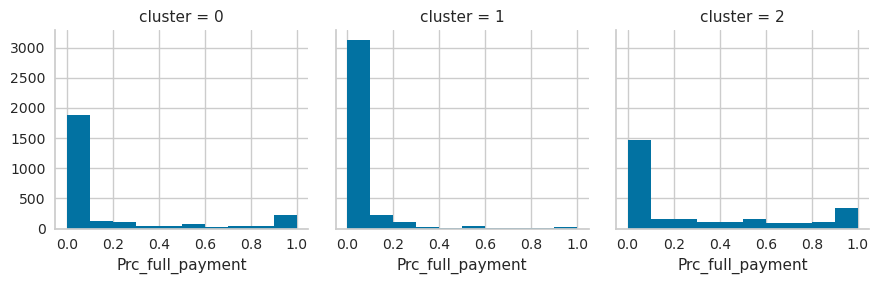

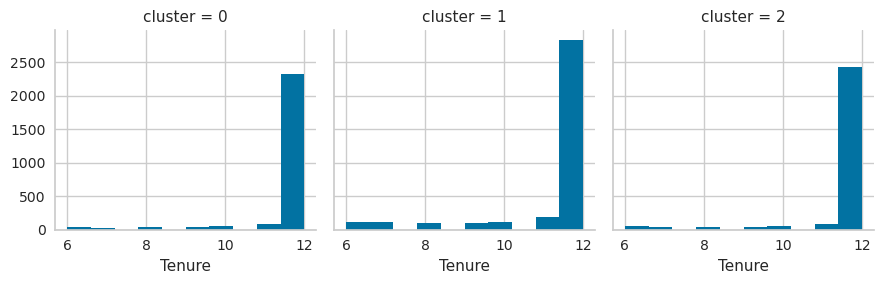

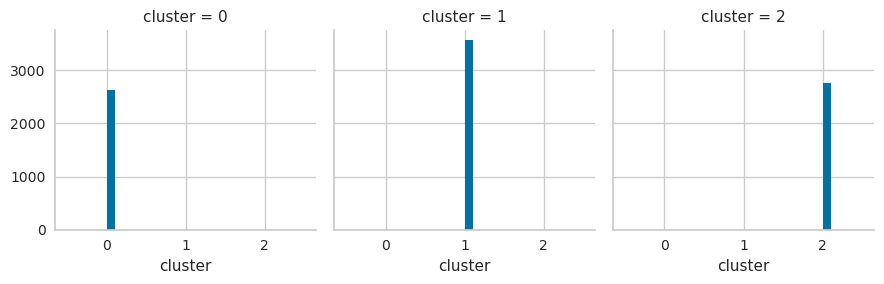

In [24]:
df['cluster'] = data['cluster']
for col in df.columns:
        grid = sns.FacetGrid(df, col='cluster')
        grid.map(plt.hist, col)
plt.show()